# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from xgboost import XGBClassifier
from tqdm import tqdm

# Data loading and data overview

In [2]:
data = pd.read_csv('diabetes_prediction_dataset.csv')

In [3]:
print("Data Head")
print(data.head())
print("\nData Info")
print(data.info())
print("\nData Describe")
print(data.describe())
print("\nData Isnull")
print(data.isnull().sum())
print("\nData Duplicated")
print(data.duplicated().sum())
print("\nData Shape")
print(data.shape)
print("\nData Columns")
print(data.columns)

Data Head
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  

Data Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1

# Label encoding for Gender and Smoking History feature

In [4]:
from sklearn.preprocessing import LabelEncoder

# Create a copy of the original dataframe to preserve it
df_encoded = data.copy()

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode 'gender' column
df_encoded['gender'] = label_encoder.fit_transform(df_encoded['gender'])

# Encode 'smoking_history' column
df_encoded['smoking_history'] = label_encoder.fit_transform(df_encoded['smoking_history'])

# Display the encoded dataframe
print(df_encoded.head())

   gender   age  hypertension  heart_disease  smoking_history    bmi  \
0       0  80.0             0              1                4  25.19   
1       0  54.0             0              0                0  27.32   
2       1  28.0             0              0                4  27.32   
3       0  36.0             0              0                1  23.45   
4       1  76.0             1              1                1  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  


# Exploratory Data Analysis

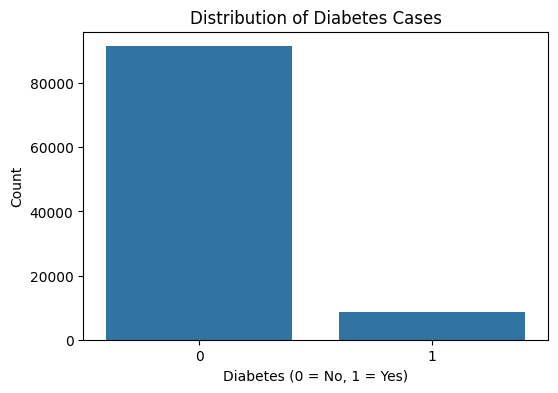

Diabetes Class Distribution (%):
diabetes
0    91.5
1     8.5
Name: proportion, dtype: float64


In [5]:
# Target variable distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='diabetes', data=df_encoded)
plt.title('Distribution of Diabetes Cases')
plt.xlabel('Diabetes (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.savefig('diabetes_distribution.png')
plt.show()

# Percentage of each class
print("Diabetes Class Distribution (%):")
print(df_encoded['diabetes'].value_counts(normalize=True) * 100)

<Figure size 1200x800 with 0 Axes>

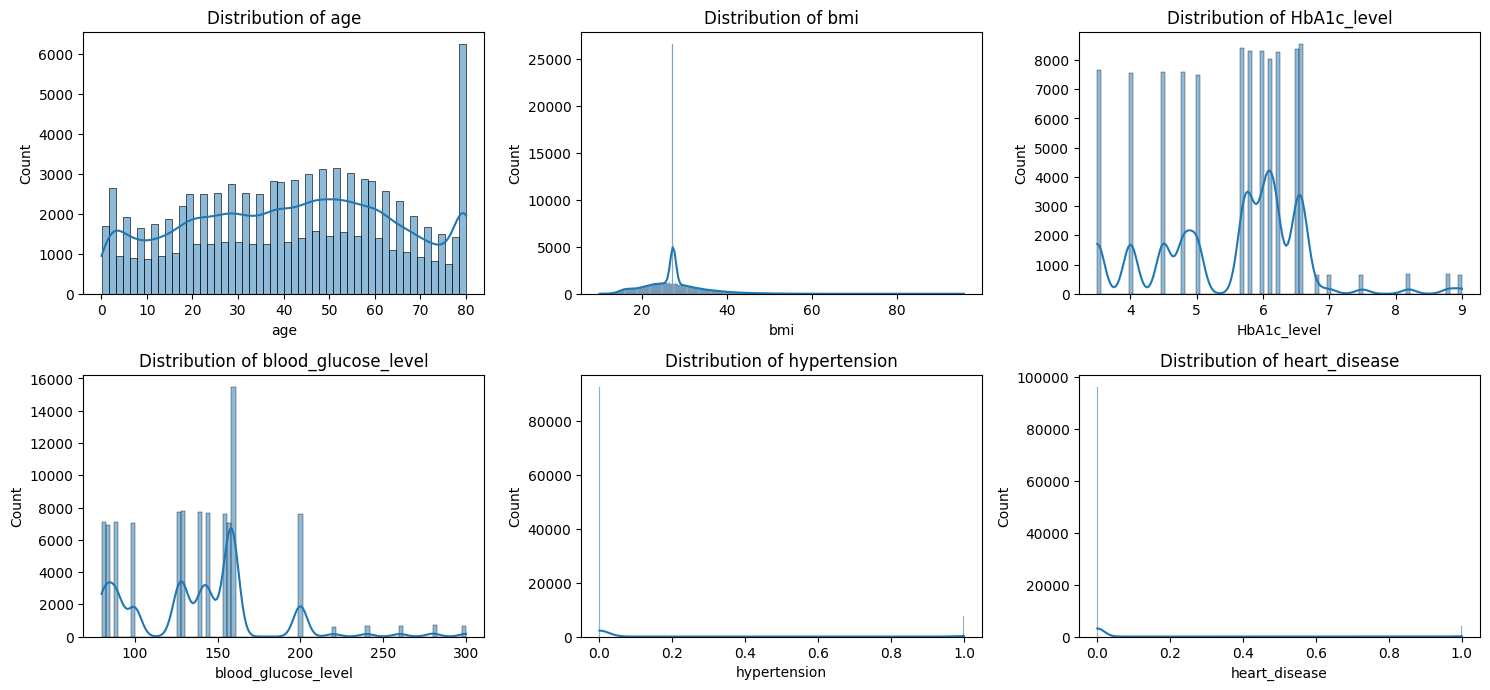

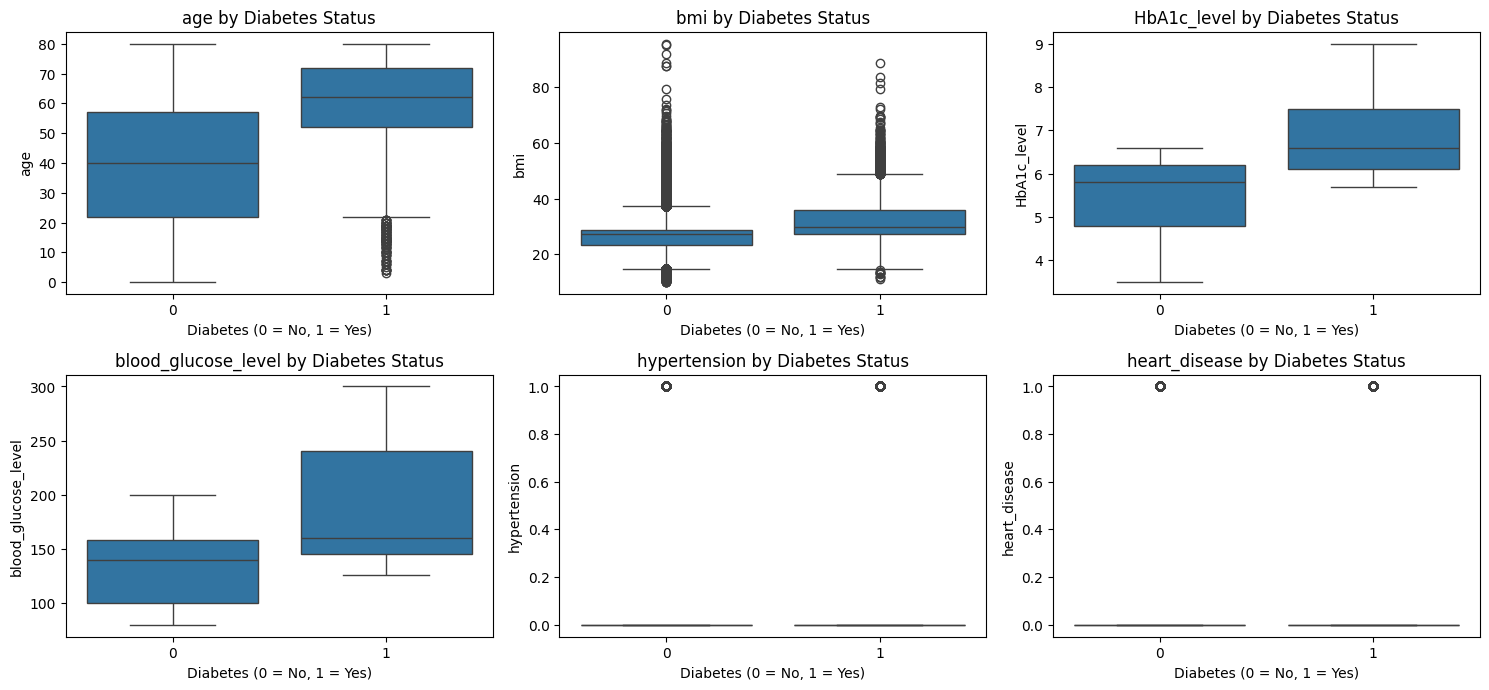

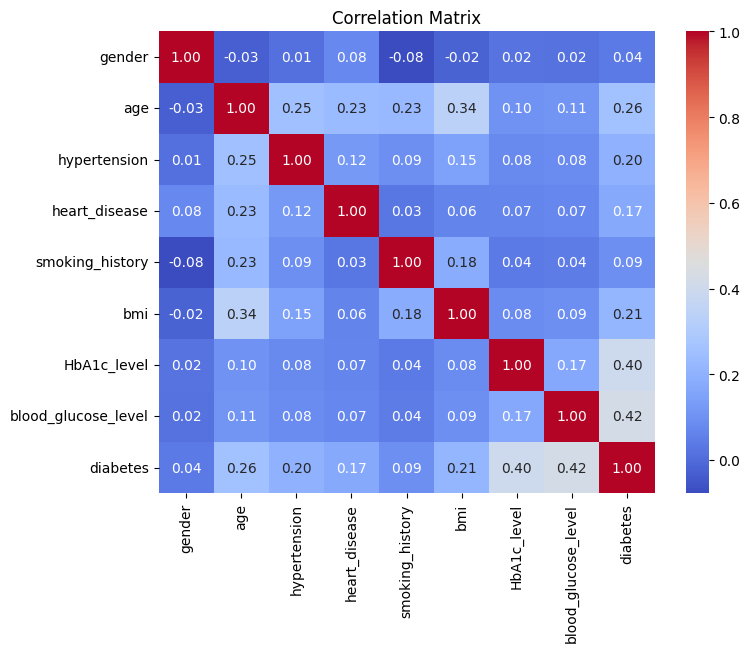

In [6]:
# Histograms for numerical features
numerical_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'hypertension', 'heart_disease']
plt.figure(figsize=(12, 8))
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)  # 3 rows, 3 columns
    sns.histplot(df_encoded[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
plt.tight_layout()
plt.savefig('numerical_distributions.png')
plt.show()


# Box plots for numerical features by diabetes status
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='diabetes', y=col, data=df_encoded)
    plt.title(f'{col} by Diabetes Status')
    plt.xlabel('Diabetes (0 = No, 1 = Yes)')
    plt.ylabel(col)
plt.tight_layout()
plt.savefig('numerical_boxplots.png')
plt.show()

# Select only numeric columns
numeric_data = df_encoded.select_dtypes(include=['number'])

# Correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png')
plt.show()

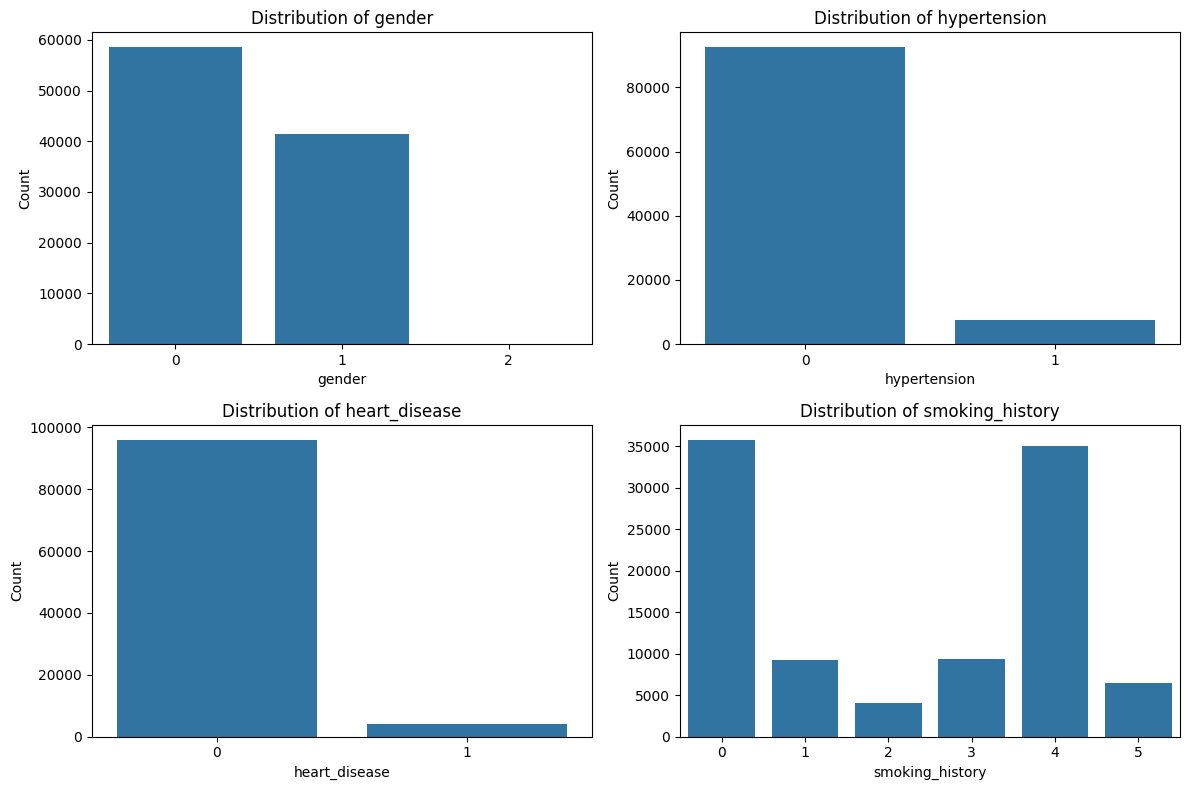

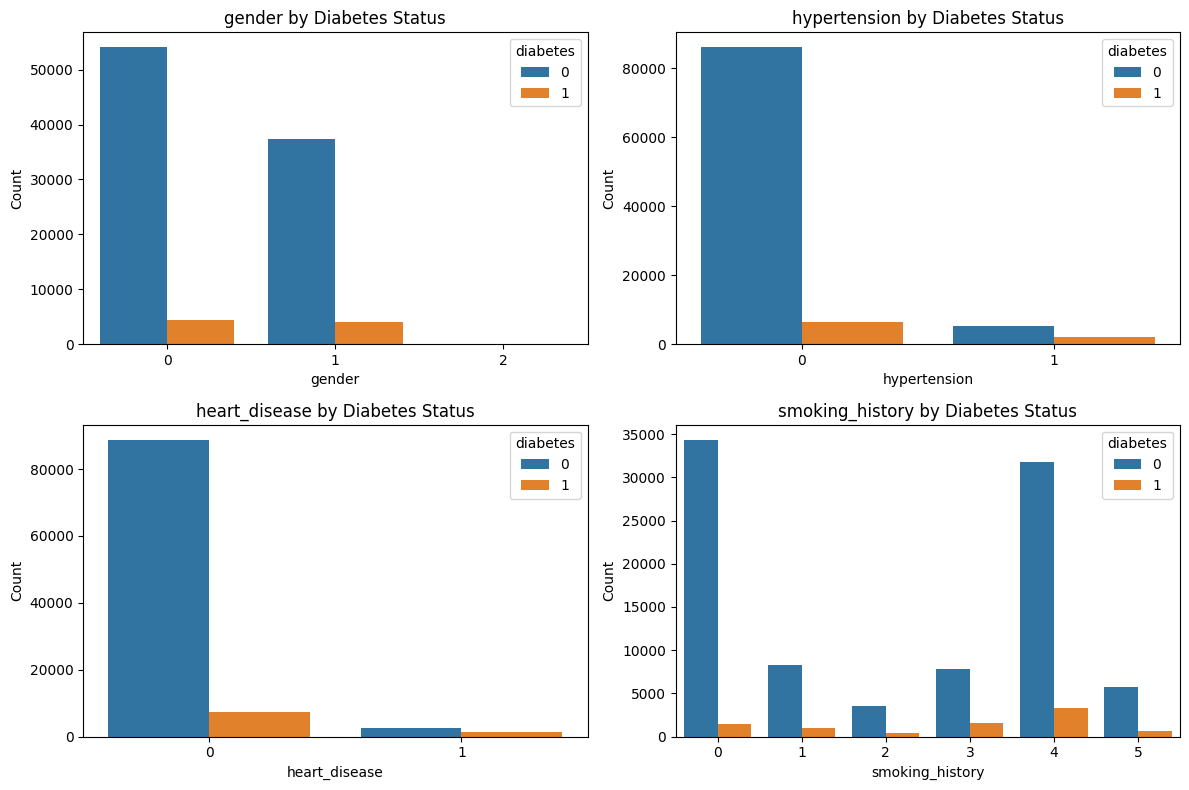


Cross-tabulation for gender and Diabetes:
diabetes           0         1
gender                        
0          92.381131  7.618869
1          90.251026  9.748974
2         100.000000  0.000000

Cross-tabulation for hypertension and Diabetes:
diabetes              0          1
hypertension                      
0             93.069232   6.930768
1             72.104208  27.895792

Cross-tabulation for heart_disease and Diabetes:
diabetes               0          1
heart_disease                      
0              92.470174   7.529826
1              67.858955  32.141045

Cross-tabulation for smoking_history and Diabetes:
diabetes                 0          1
smoking_history                      
0                95.940362   4.059638
1                89.791083  10.208917
2                88.211788  11.788212
3                82.998289  17.001711
4                90.465878   9.534122
5                89.297348  10.702652


In [7]:
# Count plots for categorical features
categorical_cols = ['gender', 'hypertension', 'heart_disease', 'smoking_history']
plt.figure(figsize=(12, 8))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=col, data=df_encoded)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
plt.tight_layout()
plt.savefig('categorical_distributions.png')
plt.show()

# Bar plots for categorical features by diabetes status
plt.figure(figsize=(12, 8))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=col, hue='diabetes', data=df_encoded)
    plt.title(f'{col} by Diabetes Status')
    plt.xlabel(col)
    plt.ylabel('Count')
plt.tight_layout()
plt.savefig('categorical_by_diabetes.png')
plt.show()

# Cross-tabulation
for col in categorical_cols:
    print(f"\nCross-tabulation for {col} and Diabetes:")
    print(pd.crosstab(df_encoded[col], df_encoded['diabetes'], normalize='index') * 100)

In [8]:
# Check prevalence of 'No Info' in smoking_history
print("Smoking History Distribution (%):")
print(df_encoded['smoking_history'].value_counts(normalize=True) * 100)

# Analyze age distribution for very young patients
print("\nPatients with age < 1 year:")
print(df_encoded[df_encoded['age'] < 1][['age', 'diabetes']].describe())

Smoking History Distribution (%):
smoking_history
0    35.816
4    35.095
3     9.352
1     9.286
5     6.447
2     4.004
Name: proportion, dtype: float64

Patients with age < 1 year:
              age  diabetes
count  911.000000     911.0
mean     0.527684       0.0
std      0.237723       0.0
min      0.080000       0.0
25%      0.320000       0.0
50%      0.560000       0.0
75%      0.720000       0.0
max      0.880000       0.0


In [9]:
# Mean values of numerical features by diabetes status
print("\nMean Values by Diabetes Status:")
print(df_encoded.groupby('diabetes')[numerical_cols].mean())

# Pair plot for numerical features
# sns.pairplot(df_encoded, vars=numerical_cols, hue='diabetes')
# plt.savefig('pair_plot.png')
# plt.show()


Mean Values by Diabetes Status:
                age        bmi  HbA1c_level  blood_glucose_level  \
diabetes                                                           
0         40.115187  26.887163     5.396761           132.852470   
1         60.946588  31.988382     6.934953           194.094706   

          hypertension  heart_disease  
diabetes                               
0             0.058984       0.029235  
1             0.245647       0.149059  


<Figure size 1200x800 with 0 Axes>

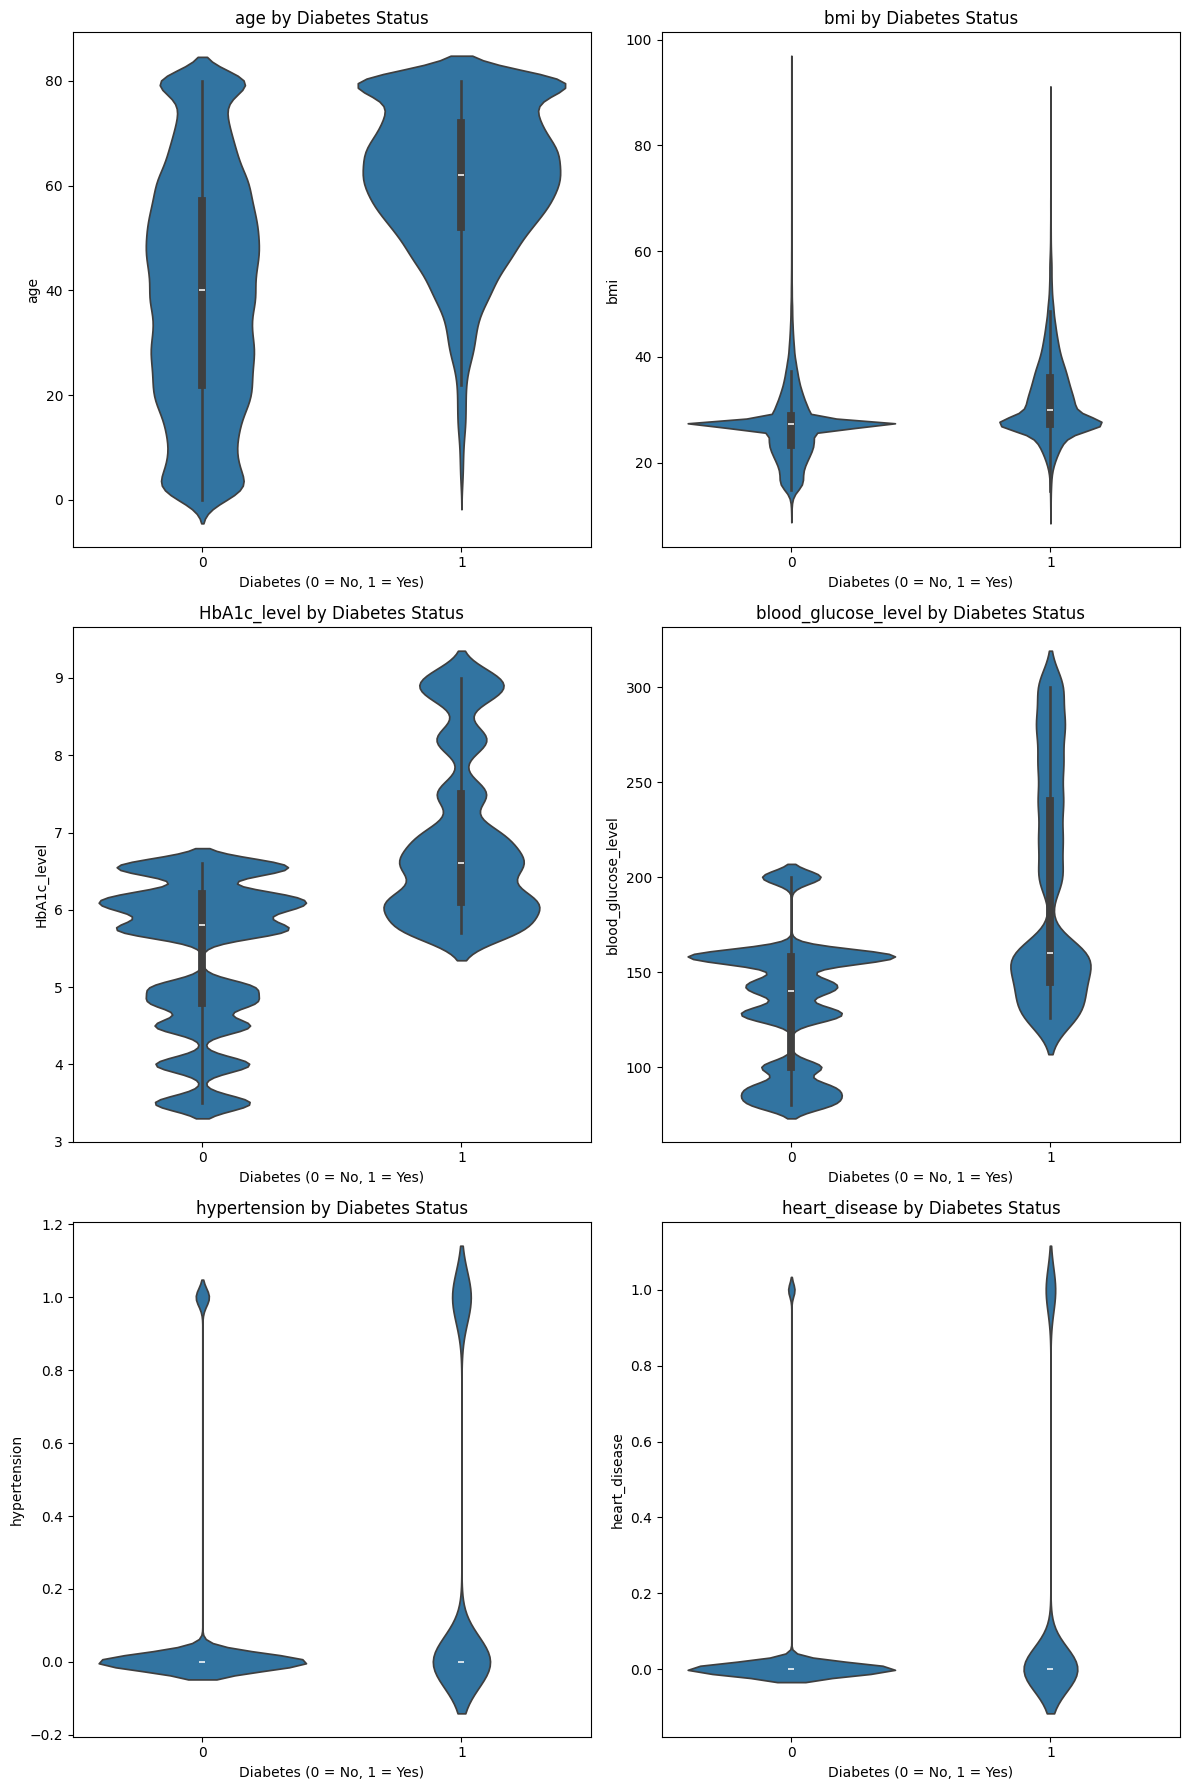

In [10]:
# Violin plots for numerical features
plt.figure(figsize=(12, 8))

# Calculate needed grid size
n_cols = len(numerical_cols)
n_rows = (n_cols + 1) // 2  # Round up division

plt.figure(figsize=(12, 6 * n_rows))  # Adjust height based on rows
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(n_rows, 2, i)
    sns.violinplot(x='diabetes', y=col, data=df_encoded)
    plt.title(f'{col} by Diabetes Status')
    plt.xlabel('Diabetes (0 = No, 1 = Yes)')
    plt.ylabel(col)
plt.tight_layout()
plt.savefig('violin_plots.png')
plt.show()

# Age binning
# df_encoded['age_group'] = pd.cut(df_encoded['age'], bins=[0, 18, 40, 60, 100], labels=['0-18', '19-40', '41-60', '61+'])
# plt.figure(figsize=(8, 6))
# sns.countplot(x='age_group', hue='diabetes', data=df_encoded)
# plt.title('Diabetes by Age Group')
# plt.xlabel('Age Group')
# plt.ylabel('Count')
# plt.savefig('age_group_by_diabetes.png')
# plt.show()

# Data Preprocessing

In [11]:
print(data.head())
print(df_encoded.head())

   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  
   gender   age  hypertension  heart_disease  smoking_history    bmi  \
0       0  80.0             0              1                4  25.19   
1       0  54.0             0              0                0  27.32   
2       1  28.0             0              0                4  27.32 

In [12]:
# Step 1: Convert 'No Info' in smoking_history to NaN
# Assuming 'No Info' was encoded as 0 (adjust if different)
df_encoded['smoking_history'] = df_encoded['smoking_history'].replace(0, np.nan)

In [13]:
# Step 2: Scale numerical features for KNN imputation
scaler_knn = StandardScaler()
numerical_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
df_encoded[numerical_cols] = scaler_knn.fit_transform(df_encoded[numerical_cols])

In [14]:
# Step 3: Apply KNN imputation for smoking_history
# Use all features except the target ('diabetes') for imputation
features_for_imputation = ['gender', 'age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'smoking_history']
imputer = KNNImputer(n_neighbors=5, weights='uniform', missing_values=np.nan)
df_encoded[features_for_imputation] = imputer.fit_transform(df_encoded[features_for_imputation])

# Convert smoking_history back to integers (KNNImputer may output floats)
df_encoded['smoking_history'] = df_encoded['smoking_history'].round().astype(int)

In [15]:
# Step 4: Filter out rows where age < 1
# Note: Age is scaled, so we need to transform the threshold (age < 1) accordingly
# Revert scaling for now, filter, and re-scale later
df_encoded[numerical_cols] = scaler_knn.inverse_transform(df_encoded[numerical_cols])
df_encoded = df_encoded[df_encoded['age'] >= 1]

In [16]:
# Step 5: Define features and target
X = df_encoded.drop('diabetes', axis=1)
y = df_encoded['diabetes']

In [17]:
# Step 6: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Step 7: Handle class imbalance using SMOTE on the training set
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [19]:
# Step 8: Scale numerical features for modeling
scaler_model = StandardScaler()
X_train[numerical_cols] = scaler_model.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler_model.transform(X_test[numerical_cols])

In [20]:
# Print shapes and label distribution to confirm preprocessing
print("Training set shape after SMOTE:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Training label distribution after SMOTE:")
print(y_train.value_counts(normalize=True) * 100)
print("Smoking history distribution after KNN imputation:")
print(df_encoded['smoking_history'].value_counts(normalize=True) * 100)

Training set shape after SMOTE: (144936, 8)
Testing set shape: (19818, 8)
Training label distribution after SMOTE:
diabetes
0    50.0
1    50.0
Name: proportion, dtype: float64
Smoking history distribution after KNN imputation:
smoking_history
4    56.619806
3    21.308117
1     9.397612
5     6.863527
2     5.810938
Name: proportion, dtype: float64


In [21]:
print(X_train.head())
print(X_test.head())
print(y_train.head())
print(y_test.head())

   gender       age  hypertension  heart_disease  smoking_history       bmi  \
0     0.0 -1.866661           0.0            0.0                4 -1.897380   
1     0.0 -1.115158           0.0            0.0                2  0.382832   
2     0.0  0.246940           0.0            0.0                3 -1.237103   
3     1.0 -0.739407           0.0            0.0                3 -0.166715   
4     0.0  1.045411           0.0            0.0                4 -0.697124   

   HbA1c_level  blood_glucose_level  
0    -0.939675            -0.408715  
1     0.288612            -1.469042  
2    -0.366474            -0.320355  
3    -1.758533             0.651612  
4    -0.120817            -0.408715  
       gender       age  hypertension  heart_disease  smoking_history  \
72675     1.0 -0.833345           0.0            0.0                4   
22658     1.0  1.139349           1.0            0.0                3   
66994     1.0  1.139349           0.0            0.0                2   
10470

# Model Training & Comparison 

In [22]:
# Define the train function
def train(X_train, X_test, y_train, y_test, model, model_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions for training and testing sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Probabilities for ROC-AUC
    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_test_prob = model.predict_proba(X_test)[:, 1]
    
    # Compute metrics for training set
    train_metrics = {
        'Accuracy': accuracy_score(y_train, y_train_pred),
        'Precision': precision_score(y_train, y_train_pred),
        'Recall': recall_score(y_train, y_train_pred),
        'F1 Score': f1_score(y_train, y_train_pred),
        'ROC-AUC': roc_auc_score(y_train, y_train_prob)
    }
    
    # Compute metrics for testing set
    test_metrics = {
        'Accuracy': accuracy_score(y_test, y_test_pred),
        'Precision': precision_score(y_test, y_test_pred),
        'Recall': recall_score(y_test, y_test_pred),
        'F1 Score': f1_score(y_test, y_test_pred),
        'ROC-AUC': roc_auc_score(y_test, y_test_prob)
    }
    
    # Print metrics
    print(f"\n{model_name} Metrics:")
    print("Training Metrics:")
    for metric, value in train_metrics.items():
        print(f"{metric}: {value:.4f}")
    print("Testing Metrics:")
    for metric, value in test_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    # Plot ROC-AUC Curve for test set
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {test_metrics["ROC-AUC"]:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC-AUC Curve - {model_name} (Test Set)')
    plt.legend()
    plt.savefig(f'roc_auc_{model_name.lower().replace(" ", "_")}.png')
    plt.show()
    
    # Plot Confusion Matrix for test set
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name} (Test Set)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f'confusion_matrix_{model_name.lower().replace(" ", "_")}.png')
    plt.show()
    
    return train_metrics, test_metrics, model

In [23]:
# List of models to compare
models = [
    (RandomForestClassifier(random_state=42), "Random Forest"),
    (LogisticRegression(random_state=42, max_iter=1000), "Logistic Regression"),
    (SVC(kernel='linear', probability=True, random_state=42), "SVM"),
    (XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), "XGBoost")
]

In [24]:
# Dictionary to store metrics for comparison
results = {'Model': [], 'Set': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': [], 'ROC-AUC': []}
trained_models = {}  # To store trained models for later use

Training models:   0%|          | 0/4 [00:00<?, ?it/s]


Random Forest Metrics:
Training Metrics:
Accuracy: 0.9993
Precision: 0.9997
Recall: 0.9989
F1 Score: 0.9993
ROC-AUC: 1.0000
Testing Metrics:
Accuracy: 0.9654
Precision: 0.8588
Recall: 0.7130
F1 Score: 0.7791
ROC-AUC: 0.9668


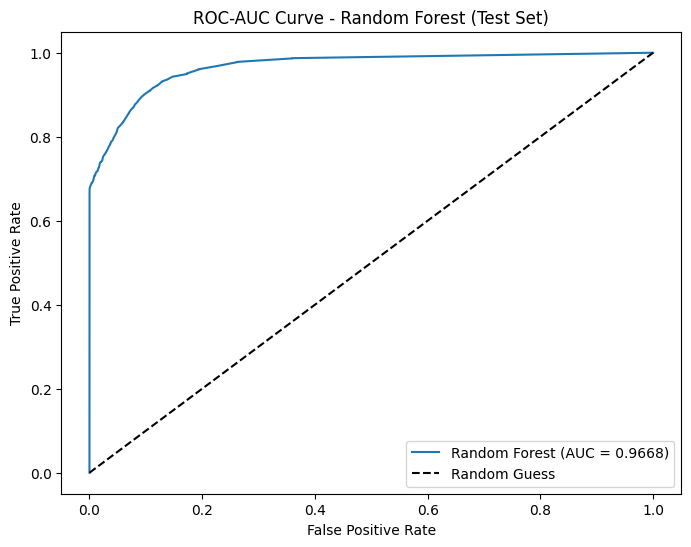

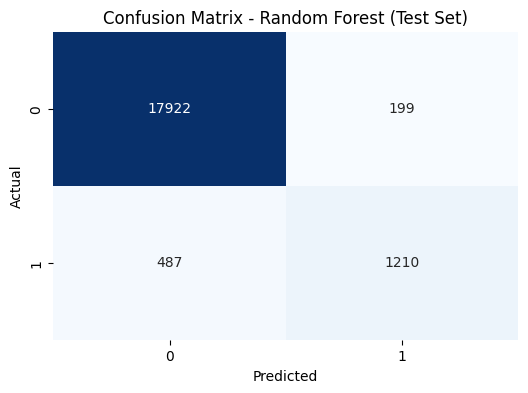

Training models:  25%|██▌       | 1/4 [00:07<00:23,  7.95s/it]


Logistic Regression Metrics:
Training Metrics:
Accuracy: 0.8898
Precision: 0.8898
Recall: 0.8899
F1 Score: 0.8898
ROC-AUC: 0.9648
Testing Metrics:
Accuracy: 0.8896
Precision: 0.4282
Recall: 0.8633
F1 Score: 0.5725
ROC-AUC: 0.9609


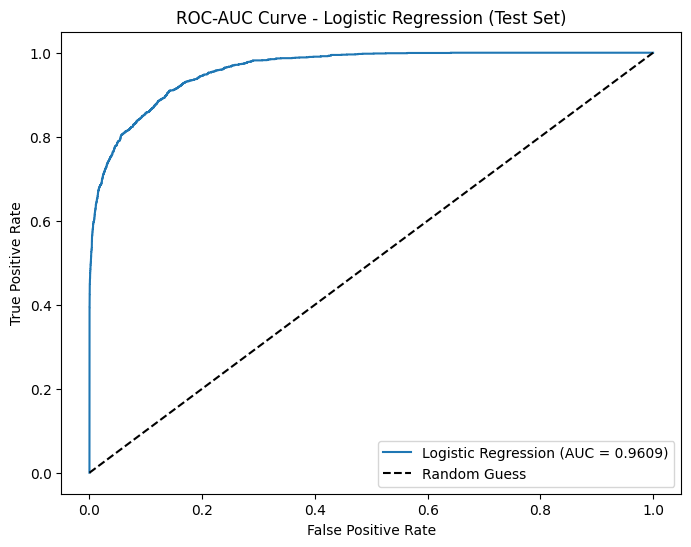

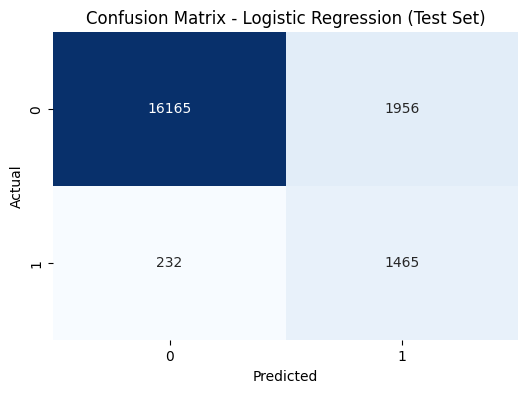

Training models:  50%|█████     | 2/4 [00:08<00:06,  3.45s/it]


SVM Metrics:
Training Metrics:
Accuracy: 0.8908
Precision: 0.8884
Recall: 0.8938
F1 Score: 0.8911
ROC-AUC: 0.9646
Testing Metrics:
Accuracy: 0.8893
Precision: 0.4278
Recall: 0.8680
F1 Score: 0.5732
ROC-AUC: 0.9609


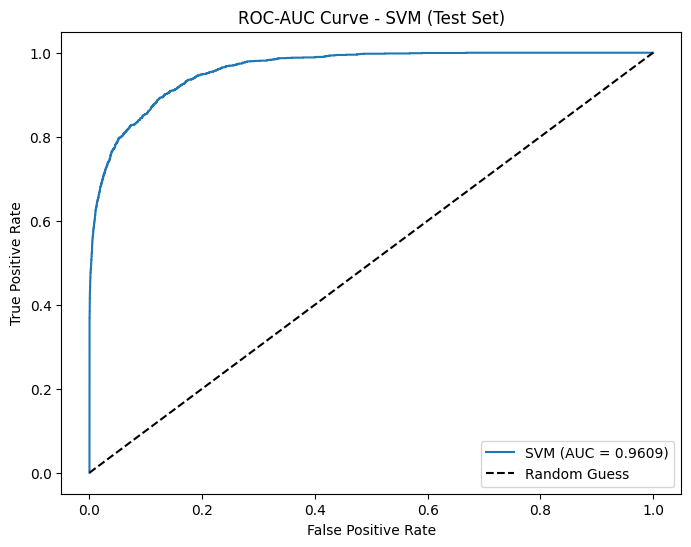

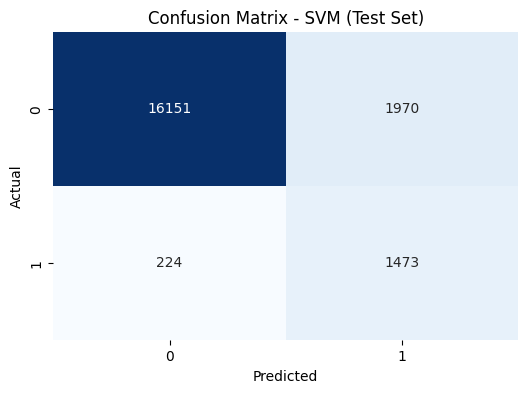

Training models:  75%|███████▌  | 3/4 [07:50<03:32, 212.73s/it]/opt/anaconda3/envs/projects/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:52:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Metrics:
Training Metrics:
Accuracy: 0.9821
Precision: 0.9981
Recall: 0.9661
F1 Score: 0.9818
ROC-AUC: 0.9985
Testing Metrics:
Accuracy: 0.9695
Precision: 0.9131
Recall: 0.7118
F1 Score: 0.8000
ROC-AUC: 0.9777


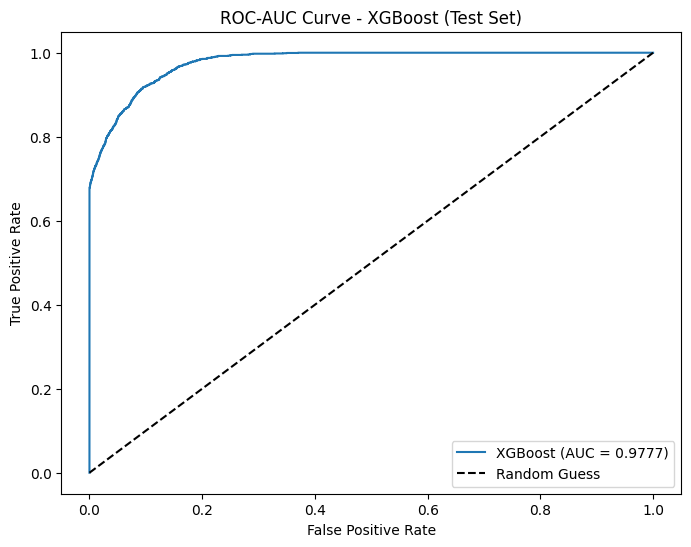

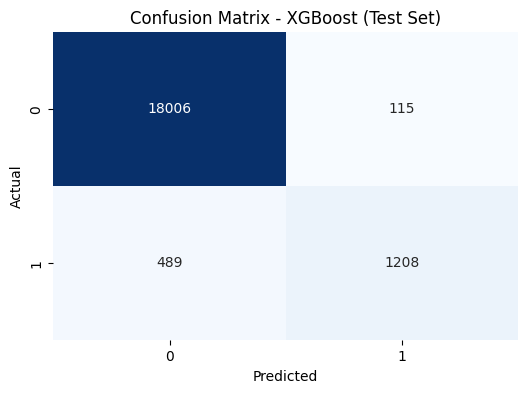

Training models: 100%|██████████| 4/4 [07:50<00:00, 117.64s/it]


In [25]:
for model, model_name in tqdm(models, desc="Training models"):
    train_metrics, test_metrics, trained_model = train(X_train, X_test, y_train, y_test, model, model_name)
    
    # Store training metrics
    results['Model'].append(model_name)
    results['Set'].append('Train')
    for metric, value in train_metrics.items():
        results[metric].append(value)
    
    # Store testing metrics
    results['Model'].append(model_name)
    results['Set'].append('Test')
    for metric, value in test_metrics.items():
        results[metric].append(value)
    
    # Store the trained model
    trained_models[model_name] = trained_model

In [26]:
# Create a DataFrame for comparison
results_df = pd.DataFrame(results) 
print("\nModel Comparison Summary:")
print(results_df)

# Optionally, save the results to a CSV file
results_df.to_csv('model_comparison_results.csv', index=False)


Model Comparison Summary:
                 Model    Set  Accuracy  Precision    Recall  F1 Score  \
0        Random Forest  Train  0.999317   0.999696  0.998937  0.999317   
1        Random Forest   Test  0.965385   0.858765  0.713023  0.779137   
2  Logistic Regression  Train  0.889820   0.889793  0.889855  0.889824   
3  Logistic Regression   Test  0.889595   0.428237  0.863288  0.572489   
4                  SVM  Train  0.890752   0.888372  0.893815  0.891085   
5                  SVM   Test  0.889293   0.427825  0.868002  0.573152   
6              XGBoost  Train  0.982109   0.998061  0.966095  0.981818   
7              XGBoost   Test  0.969523   0.913076  0.711844  0.800000   

    ROC-AUC  
0  0.999996  
1  0.966835  
2  0.964767  
3  0.960920  
4  0.964641  
5  0.960863  
6  0.998530  
7  0.977717  


In [27]:
# Separate Train and Test DataFrames
train_df = results_df[results_df['Set'] == 'Train']
test_df = results_df[results_df['Set'] == 'Test']

# List of metrics to plot (excluding ROC-AUC as per request)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

/var/folders/2p/4s57dw5130q2l_dk612zzwl00000gn/T/ipykernel_18632/415223813.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=train_df, palette='Blues_d')


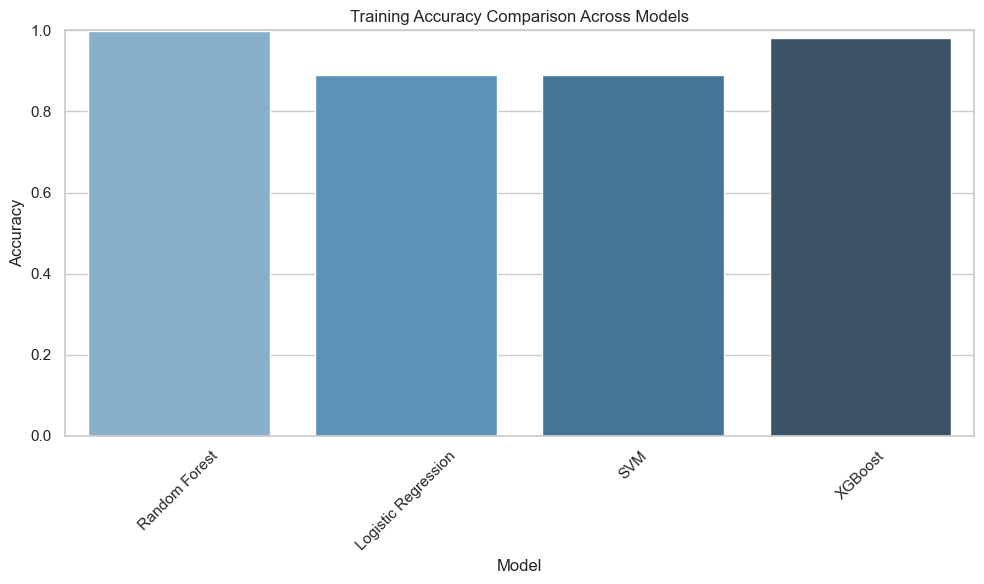

/var/folders/2p/4s57dw5130q2l_dk612zzwl00000gn/T/ipykernel_18632/415223813.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=test_df, palette='Reds_d')


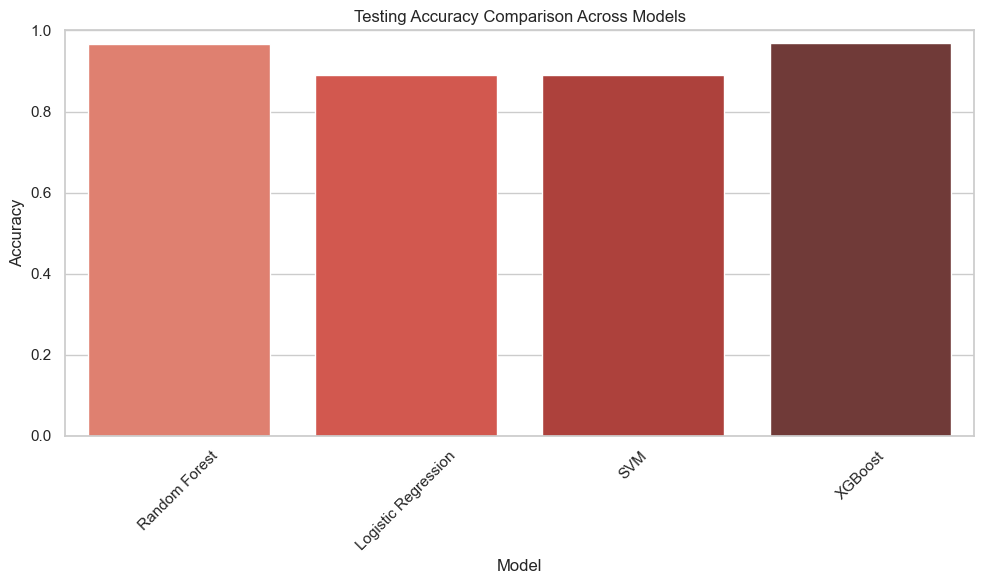

/var/folders/2p/4s57dw5130q2l_dk612zzwl00000gn/T/ipykernel_18632/415223813.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=train_df, palette='Blues_d')


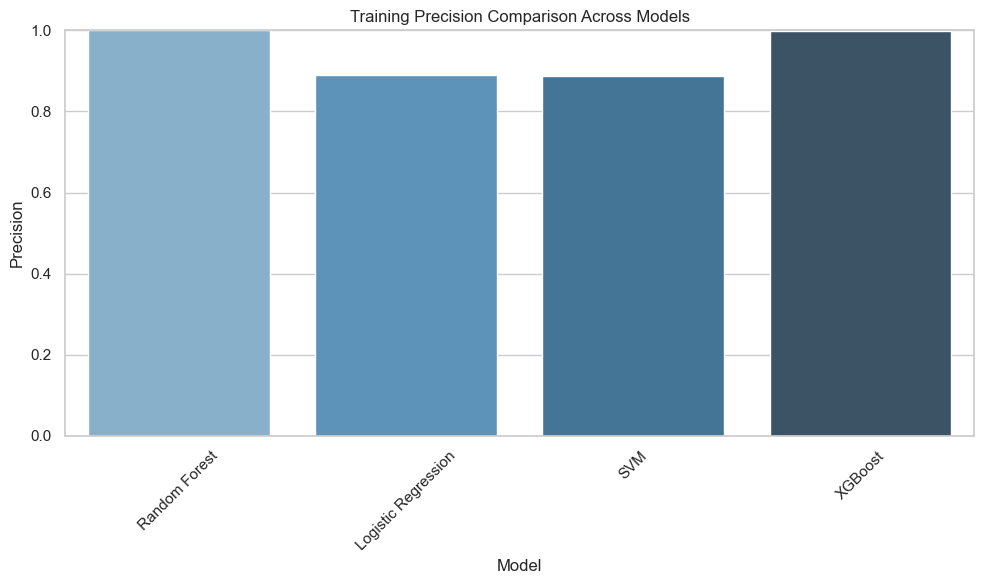

/var/folders/2p/4s57dw5130q2l_dk612zzwl00000gn/T/ipykernel_18632/415223813.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=test_df, palette='Reds_d')


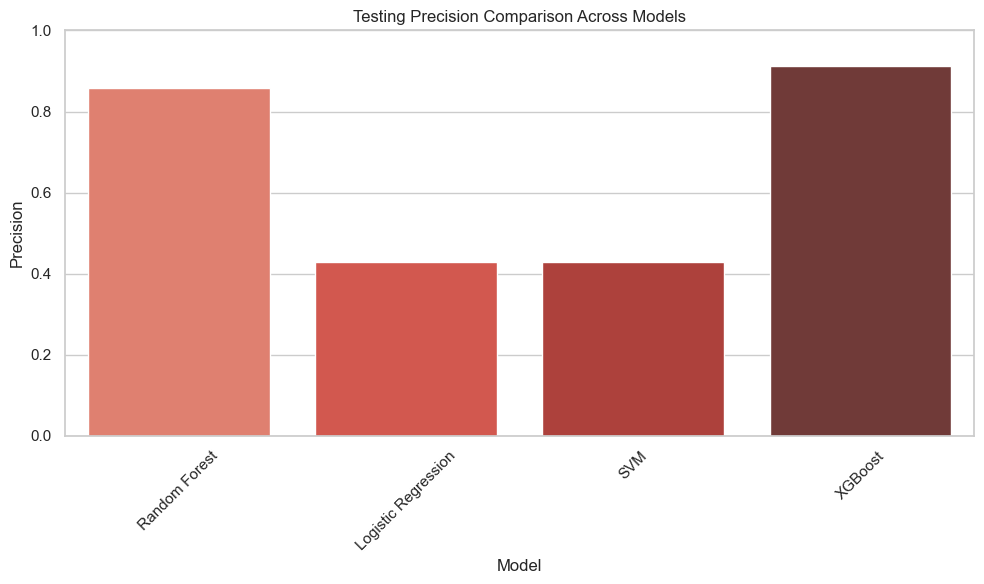

/var/folders/2p/4s57dw5130q2l_dk612zzwl00000gn/T/ipykernel_18632/415223813.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=train_df, palette='Blues_d')


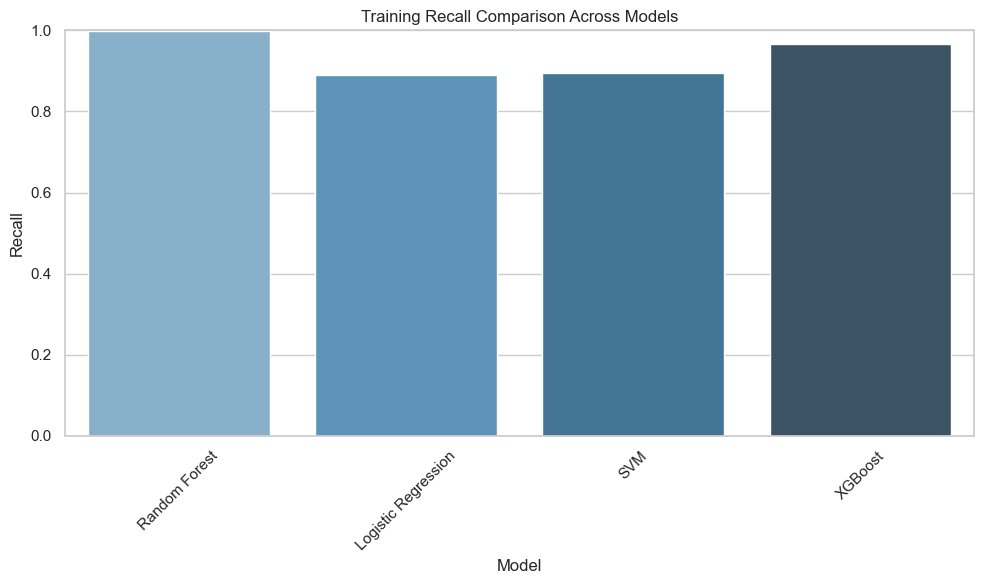

/var/folders/2p/4s57dw5130q2l_dk612zzwl00000gn/T/ipykernel_18632/415223813.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=test_df, palette='Reds_d')


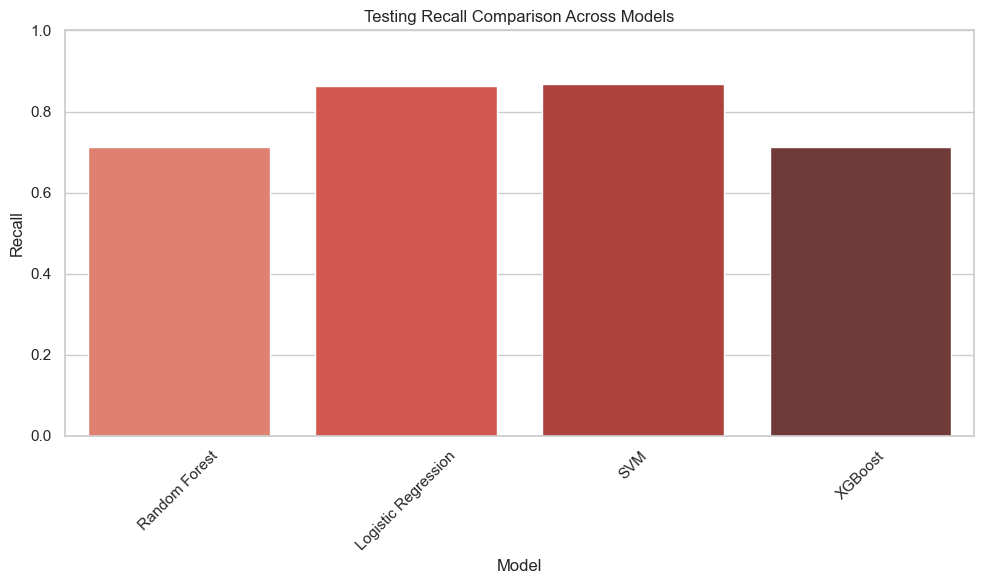

/var/folders/2p/4s57dw5130q2l_dk612zzwl00000gn/T/ipykernel_18632/415223813.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=train_df, palette='Blues_d')


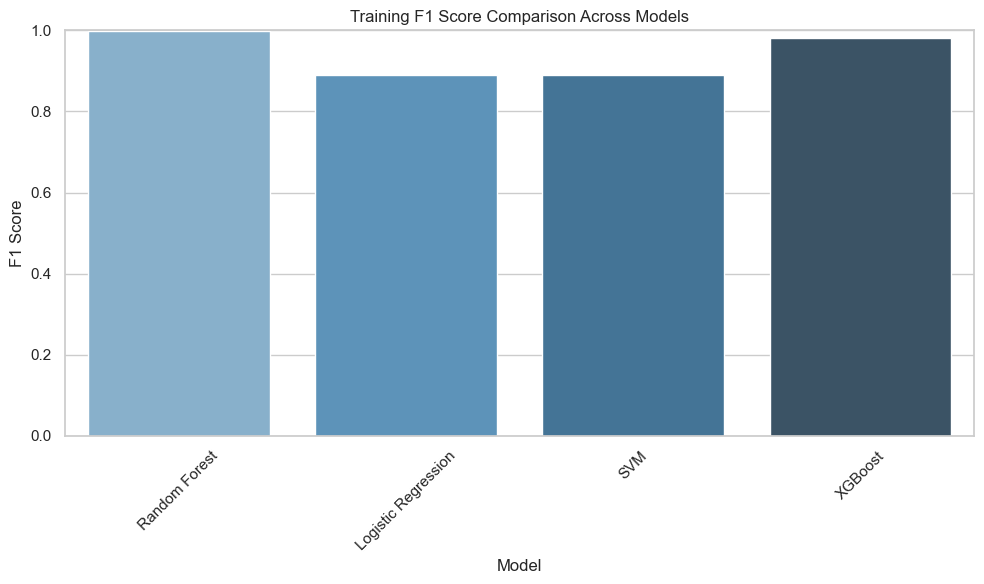

/var/folders/2p/4s57dw5130q2l_dk612zzwl00000gn/T/ipykernel_18632/415223813.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=test_df, palette='Reds_d')


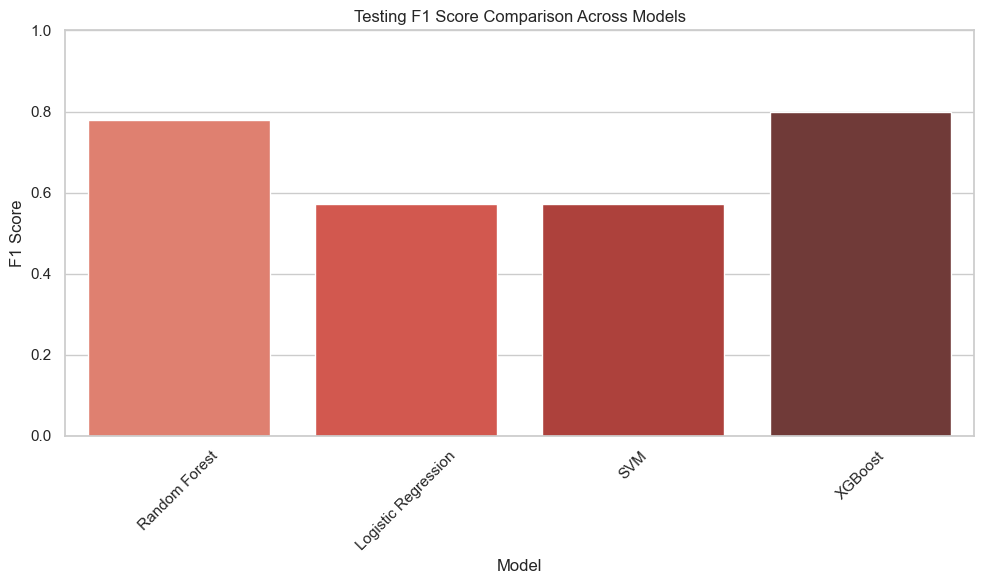

In [28]:
# Set up the plotting style
sns.set(style="whitegrid")

# Create comparison plots for each metric
for metric in metrics:
    # Plot for Training Set
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Model', y=metric, data=train_df, palette='Blues_d')
    plt.title(f'Training {metric} Comparison Across Models')
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.ylim(0, 1)  # Metrics are between 0 and 1
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'train_{metric.lower().replace(" ", "_")}_comparison.png')
    plt.show()
    
    # Plot for Testing Set
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Model', y=metric, data=test_df, palette='Reds_d')
    plt.title(f'Testing {metric} Comparison Across Models')
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.ylim(0, 1)  # Metrics are between 0 and 1
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'test_{metric.lower().replace(" ", "_")}_comparison.png')
    plt.show()